# Base Graph Convolutional Network

In [1]:
# import packages and reading in files:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomLinkSplit
import torch.nn.functional as F
import matplotlib.pyplot as plt

# import python files needed to create adjacency matrices
import reading_data

In [2]:
adjacency_matrix, mapping_index_to_node, mapping_entity_to_index = reading_data.create_adjacency_matrix_nt("data/aifb/aifb+.nt", literal_representation="filtered", sparse=True)
number_nodes = adjacency_matrix.size()[0]

In [3]:
# add the file names
file_name_train = "data/aifb/gz_files/aifb+_train_set.nt.gz"
file_name_valid = "data/aifb/gz_files/aifb+_valid_set.nt.gz"
file_name_test = "data/aifb/gz_files/aifb+_test_set.nt.gz"

labels, train_entities, valid_entities, test_entities = reading_data.training_valid_test_set(file_name_train, file_name_valid, file_name_test, mapping_entity_to_index, adjacency_matrix.size()[0])
train_mask = torch.tensor([i in train_entities for i in range(len(labels))])
valid_mask = torch.tensor([i in valid_entities for i in range(len(labels))])
test_mask = torch.tensor([i in test_entities for i in range(len(labels))])

In [4]:
feature_matrix = torch.sparse_coo_tensor(indices=torch.tensor([list(range(number_nodes)), list(range(number_nodes))]), values=torch.ones(number_nodes),size=(number_nodes, number_nodes))

In [5]:
# add training and test mask, add labels list

data_aifb = Data(x=feature_matrix, edge_index=adjacency_matrix.coalesce().indices(), num_nodes=number_nodes, y=labels.long(), train_mask=train_mask, val_mask=valid_mask, test_mask=test_mask)
number_classes = len(labels.unique())

In [25]:
class GCN(torch.nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        super().__init__()
        self.layer1 = GCNConv(input_nodes, hidden_nodes)
        self.layer2 = GCNConv(hidden_nodes, output_nodes)
    
    def forward(self, X, A):
        h1 =  self.layer1(X, A)
        h1_activated = F.relu(h1)
        h2 = self.layer2(h1_activated, A)
        h2_activated = F.log_softmax(h2, dim=1)
        return h2_activated

In [9]:
from sklearn.metrics import accuracy_score
input_n = data_aifb.num_features
hidden_n = 200
output_n = number_classes

model = GCN(input_n, hidden_n, output_n)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = list()
acc_list = list()

model.train()
for epoch in range(100):
    optim.zero_grad()
    
    output = model(data_aifb.x, data_aifb.edge_index)
    loss = F.nll_loss(output[data_aifb.train_mask], data_aifb.y[data_aifb.train_mask])
    loss.backward()
    optim.step()
    loss_list.append(loss.item())
    
     # get the predictions
    predictions = output.argmax(dim=1)

    # now, calculate, store and record everything:
    test_acc = accuracy_score(data_aifb.y[data_aifb.test_mask], predictions[data_aifb.test_mask])
    acc_list.append(test_acc)

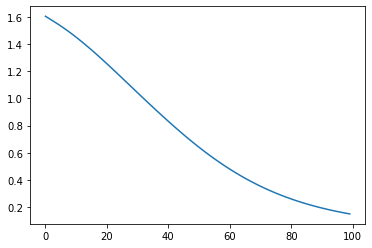

In [10]:
plt.plot(loss_list)

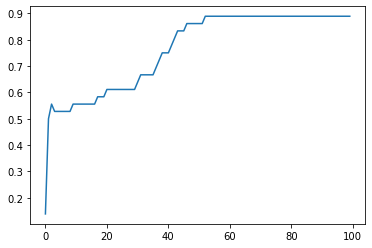

In [11]:
plt.plot(acc_list)

In [ ]:
data_aifb.test_mask.sum().item()

In [6]:
import GCN_model

In [8]:
a = GCN_model.run_gcn_model(data_aifb, 200, number_classes, "adam", 0.001, 0,
                  100, test=True, record_results=True, path_folder="test_GCN")

In [9]:
a

{'model': GCN(
   (layer1): GCNConv(2835, 200)
   (layer2): GCNConv(200, 5)
 ),
 'loss_list_train': [1.6046416759490967,
  1.5901061296463013,
  1.5756866931915283,
  1.5611282587051392,
  1.5462967157363892,
  1.5310896635055542,
  1.515407919883728,
  1.4992139339447021,
  1.4825359582901,
  1.4653772115707397,
  1.4477521181106567,
  1.4296866655349731,
  1.4112149477005005,
  1.392368197441101,
  1.3731746673583984,
  1.353660225868225,
  1.3338689804077148,
  1.3138172626495361,
  1.2935339212417603,
  1.2730395793914795,
  1.2523375749588013,
  1.2314412593841553,
  1.210373044013977,
  1.1891505718231201,
  1.1677964925765991,
  1.146342158317566,
  1.124805212020874,
  1.1032134294509888,
  1.0815989971160889,
  1.0599867105484009,
  1.0384033918380737,
  1.0168659687042236,
  0.9954068064689636,
  0.9740470051765442,
  0.9528035521507263,
  0.9316830039024353,
  0.9107000231742859,
  0.8898676037788391,
  0.8691896200180054,
  0.8486804366111755,
  0.8283472657203674,
  0.8082

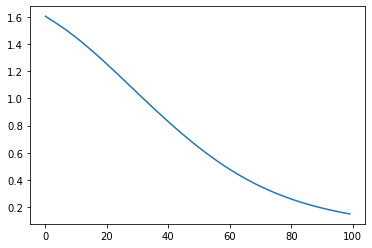

In [11]:
plt.plot(a["loss_list_train"])

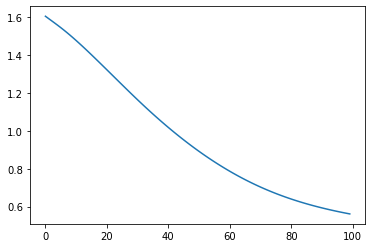

In [12]:
plt.plot(a["loss_list_test"])

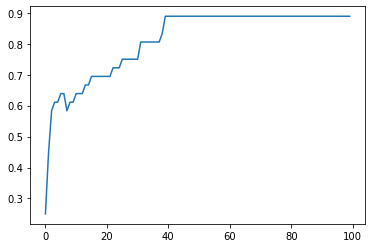

In [13]:
plt.plot(a["accuracy_test"])

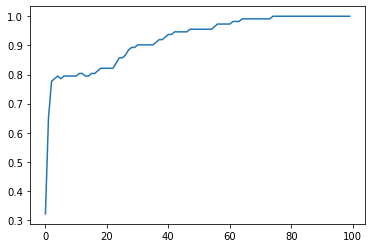

In [14]:
plt.plot(a["accuracy_train"])

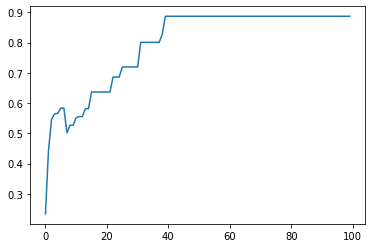

In [15]:
plt.plot(a["f1_test"])